# Visualise the lens priors

copy from overlap_models_CP (bc it is the most recent one)

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots.model_plot import ModelPlot
import lenstronomy.Util.util as util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Plots import plot_util
from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib
import pickle
import sys
import copy

from astropy.io import fits
#%matplotlib inline
from tools import *

In [5]:
# main difference: we look at the setting file rather then the results
#setting_names = ["settings_f140w_CP","settings_f814w_CP_ws","settings_f105w_CP_II_ws","settings_f160w_CP_II","settings_f475w_CP_ws"]  
#setting_names = ["settings_f105w_FINAL_wLL_ws","settings_f140w_FINAL_newLLM_III","settings_f160w_FINAL_mask_V",\
#                 "settings_f475w_FINAL_V_ws","settings_f814w_final_VII_ws"]  
setting_names = ["settings_f105w_SP_ws","settings_f140w_SP","settings_f160w_SP",\
                 "settings_f475w_SP_ws","settings_f814w_SP_ws"]  

sys.path.append("settings_same_prior/")
CP = check_if_CP(get_setting_module(setting_names[0]).setting()) #considering all of them having the same model
def rt_coord(coord_ra,coord_dec,transf_m):
    try:
        if len(coord_dec)!=len(coord_ra):
            raise ValueError("coord_ra and coord_dec must have the same lenght!")
    except:
        coord_ra,coord_dec = [coord_ra],[coord_dec]
    theta = -np.arcsin(transf_m[0][1])
    rot_matrix = np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
    
    inv_matrix = np.array([[-1,0],[0,-1]])
    if len(coord_ra)==1:
        return np.dot(np.dot([*coord_ra,*coord_dec],rot_matrix),inv_matrix)
    rt_ra,rt_dec = [] , []
    for ra,dec in zip(coord_ra,coord_dec):
        res = np.dot(np.dot([ra,dec],rot_matrix),inv_matrix)
        rt_ra.append(res[0])
        rt_dec.append(res[1])
    return np.array(rt_ra),np.array(rt_dec)

def find_rot(acoord,bcoord,creat_matr = False):
    dx = bcoord[0]-acoord[0]
    dy = bcoord[1]-acoord[1]
    intheta = np.arctan(dy/dx)
    theta = np.pi-(np.pi/2. - abs(intheta))*intheta/abs(intheta) 
    #theta = -(np.pi/2-intheta)
    if creat_matr==False:
        return theta
    else:
        return np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
def conv_e12(e1,e2,transf_m):
    theta =  np.arcsin(transf_m[0][1]) #-1 cause "reflected" image
    #e1 = [(1-q)/(1+q)] cos2phi = alpha cos2phi
    #e2 = [(1-q)/(1+q)] sin2phi = alpha sin2phi
    alpha = np.sqrt(e1**2+e2**2)
    q = (1-alpha)/(1+alpha)
    phi=0.5 * np.arctan(e2/e1)
    phi_new= (phi-theta)
    e1_rot = alpha*np.cos(2*phi_new)
    e2_rot = alpha*np.sin(2*phi_new)
    return e1_rot,e2_rot


In [9]:
#if my_machine():
#    plt.style.use(['dark_background'])

lens  0
center_x -0.24154143710423126 1.8104586086721297


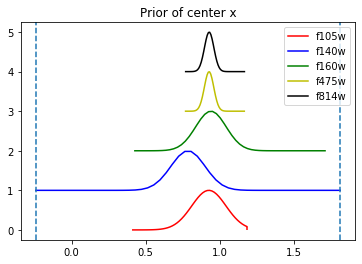

center_y -3.1701294711589507 -1.1181294253825897


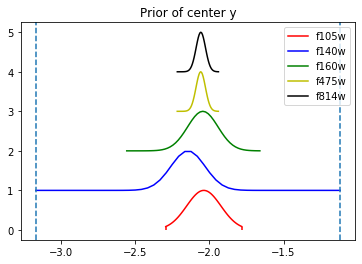

theta_E 1.4 1.7


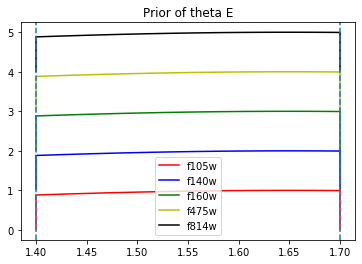

e1 -0.01 0.4


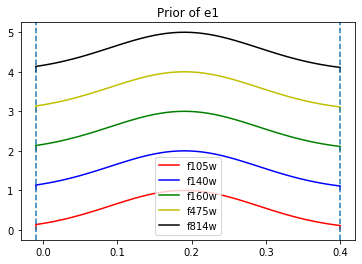

e2 -0.3 0.2


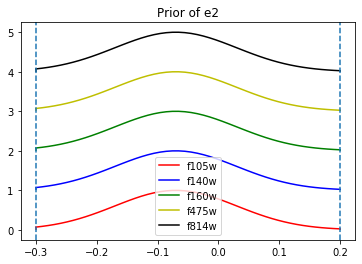

lens  1
center_x -2.062083004831903 -0.23878999285597358


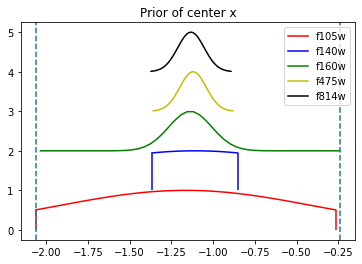

center_y -2.7514246009480594 -0.9334198411508918


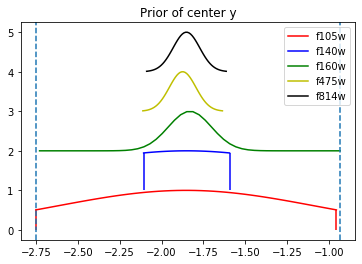

theta_E 0.0 0.35


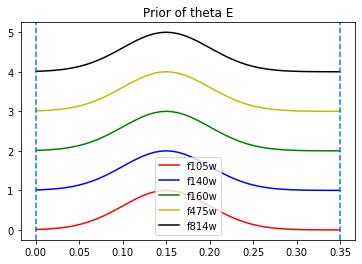

lens  2
gamma_ext 0.0 0.4


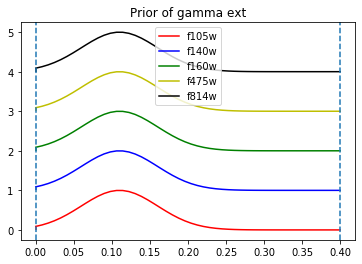

psi_ext 0.06283185307179587 -1.5707963267948966


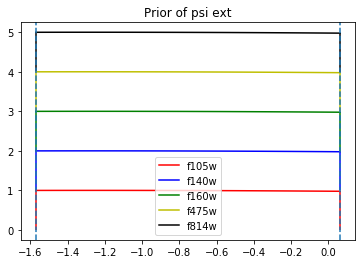

In [8]:
# Determine a list of names to copy to the current name space
lenses_kw = ["kwargs_lens_init","kwargs_lens_sigma","kwargs_lower_lens","kwargs_upper_lens"]
names     = [*lenses_kw,"transform_pix2angle","x_image","y_image"]

import scipy.integrate as integrate

class prior():
    def __init__(self,name):
        self.name =name
        self.init  = 0
        self.sigma = 0
        self.min  = 0
        self.max  = 0
        
    def fill(self,i,val):
        if i==0:#init
            self.init  = val
        elif i==1:
            self.sigma = val
        elif i==2:
            self.min = val
        elif i==3:
            self.max = val
        self.epsilon = self.sigma/1e6
    def gauss_prior(self,x):
        return np.exp(-np.power(x - self.init, 2.) / (2 * np.power(self.sigma, 2.)))
    def plt_func(self,x):
        #if np.any(x>self.max) or np.any(x<self.min):
        #    raise RuntimeError("Give only non-zero prior value")
        
        norm = np.float(integrate.quad(self.gauss_prior, self.min, self.max)[0])
        #np.piecewise(x, [x < self.min, x>self.min and x< self.max ,x >= self.max],[0,
        #return np.ones_like(x)  #self.gauss_prior(x)#/norm
        return self.gauss_prior(x)#/norm


def get_param(i_lens,CP):
    std_lens= ["center_x","center_y" , "theta_E" ]
    if i_lens==0:
        param = [*std_lens, "e1", "e2"]
        if CP:
            param+= ["gamma"]
    elif i_lens == 1:
        param = std_lens
    elif i_lens == 2:
        param =  ["gamma_ext", "psi_ext"]
    return param

def list_contain(nm,lst):
    for lst_i in lst:
        if lst_i in nm:
            return True
    return False

def get_prior(param,kws,rot_matr,im_pos):
    kw_init,kw_sigma,kw_lower,kw_upper = kws
    pr = prior(param)
    for i_kw,kw_i in enumerate(kws):
        #if "e1" in param:
        #    val,_ = conv_e12(kw_i["e1"],kw_i["e2"],rot_matr)
        #elif "e2" in param:
        #    _,val= conv_e12(kw_i["e1"],kw_i["e2"],rot_matr)
        #if  "center_x" in param:
        #    val,_ = rt_coord(kw_i["center_x"]-im_pos[0],kw_i["center_y"]-im_pos[1],rot_matr)
        #elif  "center_y" in param:
        #    _ , val = rt_coord(kw_i["center_x"]-im_pos[0],kw_i["center_y"]-im_pos[1],rot_matr)
        #if list_contain(param,["gamma","psi","theta","e1","e2"]):
        #    val = kw_i[param]

        val = kw_i[param]
        pr.fill(i_kw,val)

    return pr

col = ["r","b","g","y","k"]
lns_name=["Main","Pert","Shear"]
for lens_i in range(3): #main, pert, shear
    print("lens ",lens_i)
    for i_p, param in enumerate(get_param(lens_i,CP)): #param_i
        plt.title("Prior of "+param.replace("_"," "))
        min_i = []
        max_i = []
        for i_sett,setting_name in enumerate(setting_names):
            sett = get_setting_module(setting_name).setting()
            Acoord = [sett.x_image[0],sett.y_image[0]]
            Bcoord = [sett.x_image[2],sett.y_image[2]]
            rot_matr   = find_rot(Acoord,Bcoord,creat_matr=True)
            raim,decim = rt_coord(np.array(sett.x_image)-sett.x_image[0],np.array(sett.y_image)-sett.y_image[0],rot_matr)
            im_pos     = raim[0],decim[0]
            kws        = sett.lens_params[0][lens_i],sett.lens_params[1][lens_i],sett.lens_params[3][lens_i],sett.lens_params[4][lens_i]
            
            prior_i    = get_prior(param,kws,rot_matr,im_pos)
            x0 = np.linspace(prior_i.min,prior_i.min)
            x1 = np.linspace(prior_i.max,prior_i.max)
            epsilon = abs(prior_i.epsilon)
            x  = np.linspace(prior_i.min+epsilon,prior_i.max-epsilon)
            alpha=1
            plt.plot(x0,np.zeros_like(x0)+(i_sett),c = col[i_sett],alpha=alpha) 
            plt.plot(x ,prior_i.plt_func(x)+(i_sett),c=col[i_sett],alpha=alpha,label=setting_name.replace("settings_","")[:5]) 
            plt.plot(x1,np.zeros_like(x1)+(i_sett),c = col[i_sett],alpha=alpha) 
            #plt.vlines(prior_i.min,0,(i_sett+1)/10.,color = col[i_sett],alpha=alpha)
            #plt.vlines(prior_i.max,0,(i_sett+1)/10.,color = col[i_sett],alpha=alpha)
            plt.vlines(prior_i.min,(i_sett),prior_i.plt_func(x[0])+i_sett,color = col[i_sett],alpha=alpha)
            plt.vlines(prior_i.max,(i_sett),prior_i.plt_func(x[-1])+i_sett,color = col[i_sett],alpha=alpha)
            max_i.append(prior_i.max)
            min_i.append(prior_i.min)
        print(param,min(min_i),max(max_i))
        plt.axvline(min(min_i),ls="--")
        plt.axvline(max(max_i),ls="--")
        plt.legend()
        plt.show()
        
        